# Load modules

In [1]:
#%matplotlib inline
%load_ext autoreload
%autoreload 2

import time
import matplotlib.pyplot as plt
import math
import numpy as np
import pycuda.autoinit
import pycuda.driver as cuda
import pycuda.compiler
from pycuda.compiler import SourceModule
import sys
import gtls_simple
import gfilter
import getstat
import read_keplerlc as kep

# Loading Light Curves

In [2]:
start = time.time()
#dirlist=["/sharksuck/kic/data/0107/010748390","/sharksuck/kic/data/0082/008219268"]
dirlist=["/sharksuck/kic/data/0038/003835482","/sharksuck/kic/data/0081/008145411"]
lc,tu,n,ntrue,nq,inval=kep.load_keplc(dirlist)
#lc = 2.0 - lc
elapsed_time = time.time() - start
print (("2 :{0}".format(elapsed_time)) + "[sec]")

2 :0.8924264907836914[sec]


Here, n=72000 is divisible by 1000. Later, one can use 1000 as nby when detrending.  

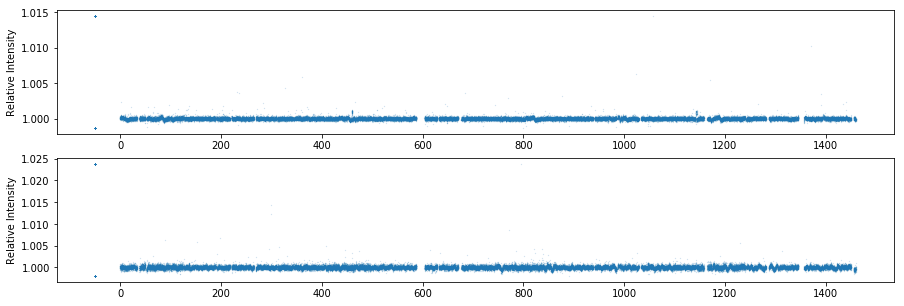

In [3]:
fig = plt.figure(figsize=(15,5))
minnq=np.min([nq,5])
for j in range(0,minnq):
    ax=fig.add_subplot(minnq,1,j+1)
    ax.plot(tu[:,j],lc[:,j],".",markersize=0.3,alpha=0.5)
    plt.ylabel("Relative Intensity")
plt.show()

# Detrend by gfilter

In [4]:
##detrend (directly use)
nby=1000 ## of thread
dev_imgout=gfilter.get_detrend(lc,nby=nby,nbx=1,r=128,isw=0,osw=1) #detrend

ydim= 72000 xdim= 2
elapsed_time:0.09944987297058105[sec]


In [5]:
##detrend (read from device) 
offset,imgout = gfilter.get_offset(n,nq,dev_imgout,tu)
print("MEAN=",offset)

MEAN= [  4.32435900e-06   7.51679636e-06]


## Load and Plot Detrended LCs (not necessary for analysis)

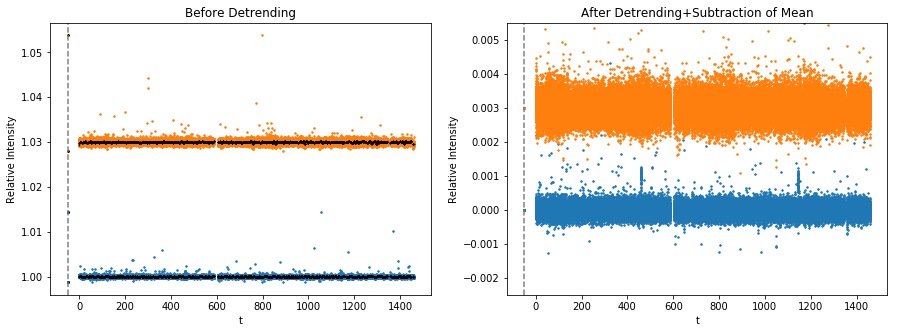

In [6]:
    ##detrend (read from device)
    imgout=imgout-offset  
    #plot
    fig = plt.figure(figsize=(15,5))
    ax=fig.add_subplot(121)
    #plt.ylim(-0.0015+1,0.0015+1)
    for j in range(0,np.min([nq,5])):
        ax.plot(tu[:,j], (lc[:,j]+0.03*j),".",markersize=3)
        ax.plot(tu[:,j], (lc[:,j]-imgout[:,j]+0.03*j),".",c="black",markersize=0.3,alpha=0.5)
    #plt.ylim(-0.0025,0.015)
    plt.axvline(inval,color="gray",ls="dashed")
    plt.title("Before Detrending")
    plt.xlabel("t")
    plt.ylabel("Relative Intensity")
    ax=fig.add_subplot(122)
    for j in range(0,np.min([nq,5])):
        ax.plot(tu[:,j], imgout[:,j]+0.003*j,".",markersize=3)
    plt.axvline(inval,color="gray",ls="dashed") #masked data
    plt.ylim(-0.0025,0.0055)
    plt.title("After Detrending+Subtraction of Mean")
    plt.xlabel("t")
    plt.ylabel("Relative Intensity")
    plt.show()

# TLS fitting by gtls

In [7]:
#tbls setting   
# Max and Min of Widths 
wmin = 24 # grid time unit
wmax = 24*8
dw=0.5
nw=int((wmax-wmin)/dw)
# the number of a scoop
nsc=int(wmax+1.0)
#time
t0min=(wmin/2)
t0max=n-wmin/2
dt=1.0
nt=int((t0max-t0min)/dt)
#L 
nl=1

In [8]:
nsc, nw, nl

(193, 336, 1)

In [1]:
    tu=np.array(tu,order="C").astype(np.float32)
#    imgout=np.array(imgout,order="F").astype(np.float32)
    #lc=np.copy(imgout)    
    #dev_ntrue = cuda.mem_alloc(ntrue.nbytes)
    #cuda.memcpy_htod(dev_ntrue,ntrue)
    
    dev_tu = cuda.mem_alloc(tu.astype(np.float32).nbytes)
    cuda.memcpy_htod(dev_tu,tu.astype(np.float32))
    ntrue=ntrue.astype(np.uint32)
    dev_ntrue = cuda.mem_alloc(ntrue.nbytes)
    cuda.memcpy_htod(dev_ntrue,ntrue)   
    #output
    #TLS s/n
    tlssn=np.zeros(n*nq).astype(np.float32)
    dev_tlssn = cuda.mem_alloc(tlssn.nbytes)
      
    source_module=gtls_simple.gtls_module()
    nthread=256

    ##compute kma,kmi,kkmi
    sharedsize=nsc*2

NameError: name 'np' is not defined

In [12]:
    #gtls
    start = time.time()
    source_module=gtls_simple.gtls_module()
    pkernel=source_module.get_function("gtls")
    pkernel(dev_tlssn,dev_imgout,dev_tu,dev_ntrue,\
            np.uint32(n),np.uint32(nw),np.uint32(nt),\
            np.uint32(nl),np.uint32(nsc),\
            np.float32(t0min),np.float32(dt),\
            np.float32(wmax),np.float32(dw),\
            block=(nthread,1,1), grid=(int(nt),int(nq)),shared=sharedsize)
    #cuda.memcpy_dtoh(blsp,dev_blsp)
    #print(blsp)

    elapsed_time = time.time() - start
    print (("gtls :{0}".format(elapsed_time)) + "[sec] for # of batch="+str(nq))

LaunchError: cuModuleLoadDataEx failed: the launch timed out and was terminated - 

# Extract Statistics

In [41]:
Pest,sde,phasebest1,phasebest2=getstat.get_blsstat(dev_blsp,dev_phase1,dev_phase2,nf,nq,df,fmin)

In [42]:
print(Pest)
print(sde)
print(phasebest1/nb)
print(nb)
pphase1=Pest*phasebest1/nb
pphase2=Pest*phasebest2/nb
print(pphase1)
print(pphase2)

[ 4.88806335  6.24648635]
[ 59.76573344  27.55149541]
[ 0.85644531  0.51171875]
1024
[ 4.18635894  3.19644419]
[ 4.28660243  3.55024908]


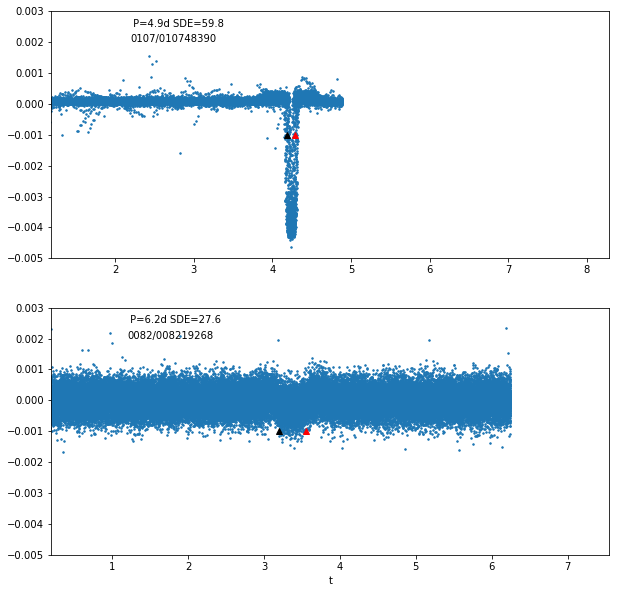

In [49]:
    #plot
    fig = plt.figure(figsize=(10,10))
    for j in range(0,np.min([nq,5])):
        ax=fig.add_subplot(np.min([nq,5]),1,j+1)
        ax.plot(np.mod(tu[:,j],Pest[j]), imgout[:,j],".",markersize=3)
        ax.plot([pphase1[j]],-0.001,"^",color="black")
        ax.plot([pphase2[j]],-0.001,"^",color="red")
        plt.xlim(pphase1[j]-3,pphase2[j]+4)
        plt.ylim(-0.005,0.003)
        plt.text(pphase1[j]-2,0.002,dirlist[j].replace("/sharksuck/kic/data/",""))
        plt.text(pphase1[j]-2,0.0025," P="+str(round(Pest[j],1))+"d"+" SDE="+str(round(sde[j],1)))
    plt.xlabel("t")
    plt.savefig("keplerBLS.png")
    plt.show()

## Show the BLS spectra (not necessary for analysis)

In [44]:
#load BLS spectra on device
cuda.memcpy_dtoh(blsp,dev_blsp)
print(blsp)

[  1.23618920e-05   1.32111427e-05   1.29081718e-05 ...,   4.69314455e-06
   5.08984886e-06   5.52152596e-06]


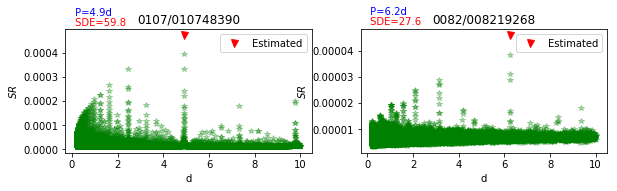

In [45]:
    freq = np.arange(fmin, df*nf+fmin, df)[0:nf]
    fig = plt.figure(figsize=(15,5))
    for j in range(0,nq):
        ax=fig.add_subplot(2,3,j+1)
        #ax.plot(Ptrue[j],0.0,"^",c="blue",markersize=7,label="Input")
        ax.plot(Pest[j],np.max(blsp[0+j*nf:nf+j*nf])*1.2,"v",c="red",markersize=7,label="Estimated")
        ax.legend()
        ax.plot(1/freq, blsp[0+j*nf:nf+j*nf], 'g*',alpha=0.3)
        plt.text(0.0,np.max(blsp[0+j*nf:nf+j*nf])*1.3," SDE="+str(round(sde[j],1)),color="red")
        plt.text(0.0,np.max(blsp[0+j*nf:nf+j*nf])*1.4," P="+str(round(Pest[j],1))+"d",color="blue")
        plt.ylabel(r"$SR$")
        plt.title(dirlist[j].replace("/sharksuck/kic/data/",""))
        plt.xlabel("d")
        #plt.xlim(0.,10)
    plt.savefig("SLCBLS.png")
    plt.show()

In [18]:
    import blstest
    out1= np.zeros(nq*n).astype(np.float32)
    cuda.memcpy_dtoh(out1, dev_imgout)
    lc = out1.reshape((n,nq))
    tt=tu[:,0]
    mask=(tt>=0)
    #python-bls
    start = time.time()
    ntr, t0, ing, eg, f_1, blsx, nb, bper, bpow, depth, qtran, duration, in1, in2, phase1, phase2=\
    blstest.compute_bls(tt[mask], lc[:,0][mask], df, nf, nb, qmi, qma, fmin)
    #blstest.compute_bls(tu, imgout[:,0], df, nf, nb, qmi, qma, fmin)
        #blstest.compute_bls(tu, lc[:,0], df, nf, nb, qmi, qma, fmin)
    print(blsx)
    elapsed_time = time.time() - start
    print (("python-bls :{0}".format(elapsed_time)) + "[sec] for 1 LC")
    #print(len(np.arange(0.3, 0.001*nf+0.3, 0.001)),nf)

Complete
[  1.65088579e-05   1.77979392e-05   1.92325791e-05 ...,   9.45194153e-06
   9.10561727e-06   9.06711254e-06]
python-bls :7.554609537124634[sec] for 1 LC


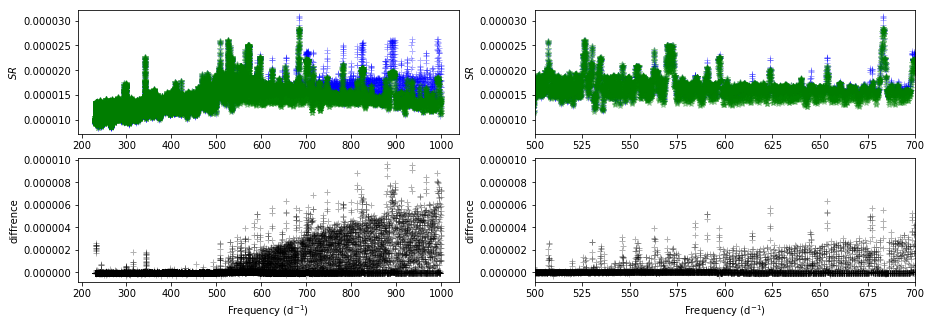

In [19]:
    freq = np.arange(fmin, df*nf+fmin, df)[0:nf]
    fig = plt.figure(figsize=(15,5))
    ax=fig.add_subplot(221)
    ax.plot(1/freq, blsx, 'b+',alpha=0.3)
    ax.plot(1/freq, blsp[0:nf], 'g*',alpha=0.3)
    plt.ylabel(r"$SR$")
    ax=fig.add_subplot(222)
    ax.plot(1/freq, blsx, 'b+',alpha=0.3)
    ax.plot(1/freq, blsp[0:nf], 'g*',alpha=0.3)
    plt.ylabel(r"$SR$")
    plt.xlim(500,700)
    ax=fig.add_subplot(223)
    ax.plot(1/freq, (np.array(blsx)-np.array(blsp[0:nf])), 'k+',alpha=0.3)
    plt.ylabel("diffrence")
    plt.xlabel(r"Frequency (d$^{-1}$)")
    ax=fig.add_subplot(224)
    ax.plot(1/freq, (np.array(blsx)-np.array(blsp[0:nf])), 'k+',alpha=0.3)
    plt.ylabel("diffrence")
    plt.xlabel(r"Frequency (d$^{-1}$)")
    plt.xlim(500,700)
    plt.show()